<a href="https://colab.research.google.com/github/nguyetha79/weather-forecast/blob/main/zeitreihenprognose_wettervorhersage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Zeitreihenprognose für die Wettervorhersage**

Für dieses Beispiel sollen Zeitreihen-Daten von Wetterwerten benutzt werden (https://keras.io/examples/timeseries/timeseries_weather_forecasting/). Sie können in dieser Aufgabe den Code von Keras benutzen (oder auch einen anderen). Geben Sie auf jeden Fall ihre Quelle an!

Modifizieren Sie das Modell so, dass Sie bei predictions die Ausgaben des LSTM-Layers "abfangen" können (siehe z.B. das Notebook LSTM deterministisch) Lernerfolg eines LSTM: Welche Fehler macht das Model nach jedem Lernschritt: visualisieren der Vorhersage eines festen Abschnitts der Zeitreihe. Welchen Einfluss hat die Kontextgöße?

## **Theoretische Konzepte**

### **1. Zeitreihendaten**
- Zeitreihendaten sind eine spezielle Art sequenzieller Daten. Diese Daten zeichnen sich dadurch aus, dass jedem Datenpunkt eine Zeitdimension zugeordnet ist.

- Jeder Datenpunkt hat einen Zeitstempel, der die Reihenfolge der Datenpunkte bestimmt. In der Regel bestehen diese Datenpunkte aus aufeinanderfolgenden Messungen, die von derselben Quelle in regelmäßigen Zeitintervallen erfasst wurden.

- Zeitreihendaten werden verwendet, um Veränderungen im Laufe der Zeit zu analysieren und nachzuvollziehen.


### **2. LSTM**

- **LSTM** ist ein tiefes, sequenzielles neuronales Netz bzw. eine Erweiterung traditioneller rekurrenter neuronaler Netze, die speziell darauf ausgelegt ist, das Problem des verschwindenden Gradienten zu lösen, indem es eine bessere Speicherung von Langzeitabhängigkeiten ermöglicht.

- Ein **LSTM**-Netzwerk ist aus Zellen (oder Einheiten) zusammengesetzt, von denen jede mehrere Tore enthält:
  - Das ***Input-Gate*** entscheidet, welche neuen Informationen hinzugefügt werden sollen.
  - Das ***Forget-Gate*** bestimmt, welche Informationen vergessen werden sollen.
  - Das ***Output-Gate*** kontrolliert die Ausgabe der Zelle basierend auf ihrem aktuellen Zustand und den Eingangsinformationen.

Diese Strukturen ermöglichen es den **LSTM**-Netzwerken, Informationen über längere Zeiträume hinweg ohne signifikanten Informationsverlust zu speichern und abzurufen.


### **3. Warum LSTM für Zeitreihenvorhersagen**
- LSTM Netzwerke haben sich als besonders wirksam für die Prognose und Analyse von Zeitreihendaten erwiesen. Dies gilt für eine breite Palette von Anwendungen, einschließlich der Wettervorhersage.

 - Da es sich bei den Zeitreihendaten bereits um eine Folge aufeinander folgender Messungen handelt, die in zeitlicher Reihenfolge indiziert sind, d. h. die Daten sind endgültig, sequentiell und periodisch, sind sie perfekt für ein LSTM-Netzwerk geeignet

 - Dank ihrer Fähigkeit, historische Daten über längere Zeiträume zu speichern und zu verarbeiten, können LSTM-Netzwerke präzisere Vorhersagen über zukünftige Trends in den Daten treffen. Dies ist besonders nützlich in Szenarien, in denen sich das Verhalten im Laufe der Zeit ändert und von zahlreichen variablen Faktoren beeinflusst wird.



## **Erstellung des Machine Learning-Modells mit TensorFlow**

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow

### **1. Set up**
Wir laden zunächst die erforderlichen Bibliotheken.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### **2. Klimadaten Zeitreihen**

- Das Jena-Klima ist ein Wetter-Zeitreihendatensatz, der an der
Wetterstation des **Max-Planck-Instituts** für Biogeochemie in Jena, Deutschland, aufgezeichnet wurde. Der Datensatz besteht aus 14 verschiedenen Größen (wie Lufttemperatur, Luftdruck, Luftfeuchtigkeit, Windrichtung usw.), die alle 10 Minuten über mehrere Jahre hinweg aufgezeichnet wurden. Dieser Datensatz umfasst Daten vom 1. Januar 2009 bis zum 31. Dezember 2016.

- Wir werden den `Zip`-Inhalt in eine `csv`-Datei extrahieren und den Inhalt dieser Datei mit der Bibliothek pandas mit einem Datenrahmen verknüpfen.

In [ ]:
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **3. Rohdaten visualisieren**

- Um uns ein Verständnis für unsere Daten zu vermitteln, wurden die einzelnen Feature im Folgenden grafisch dargestellt. Dies zeigt das eindeutige Muster jedes Features über den Zeitraum von 2009 bis 2016.  Darüber hinaus gibt sie an, wo sich Anomalien befinden, die während der Normalisierung behoben werden.

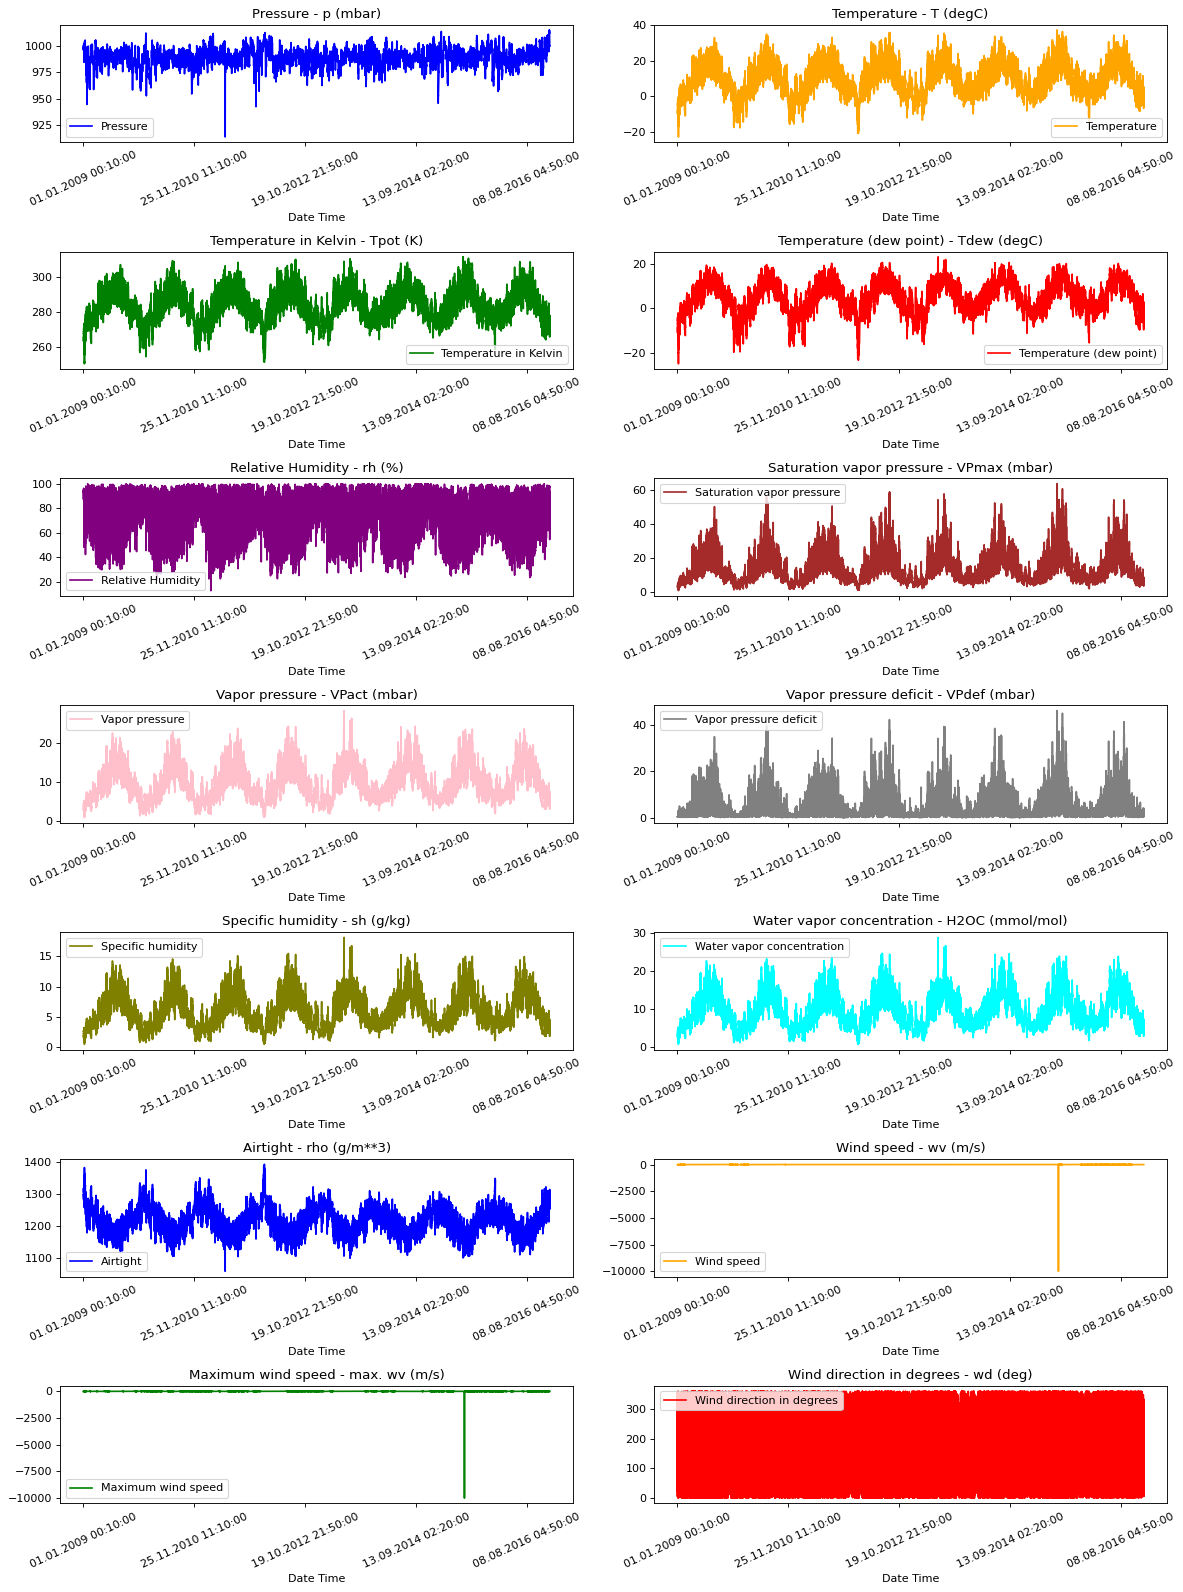

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

### **4. Daten vorverarbeiten**

####**4.1. Down Sampling**

- Wir wählen in diesem Fall ~300.000 Datenpunkte für das Training. Eine Aufzeichnung einer Beobachtung erfolgt alle 10 Minuten, also sechsmal pro Stunde. Da über einen Zeitraum von 60 Minuten keine signifikanten Änderungen zu erwarten sind, werden wir den Datensatz jede Stunde auf einen einzelnen Datensatz herunterrechnen.

- Dies kann über den Parameter `sampling_rate` der Methode `timeseries_dataset_from_array` aus der Keras Preprocessing-Bibliothek erfolgen. Dieses Argument sollte also auf 6 gesetzt werden, um das gewünschte Downsampling zu erreichen.

- 71,5 % der Daten werden zum Trainieren des Modells verwendet, d. h. 300.693 Zeilen. `split_fraction` kann geändert werden, um diesen Prozentsatz zu ändern.

- Wichtig dabei ist, wir werden den Wert `past` haben, den später angegeben werden. Diese Daten werden verwendet, um die Temperatur nach 72 Zeitstempeln (72/6=12 Stunden) vorherzusagen. Das heißt, die Temperatur nach 72 (12 Stunden * 6 Beobachtungen pro Stunde) Beobachtungen wird als Label verwendet.

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

####**4.2. Daten normalisieren**

- Da jedes Feature Werte mit unterschiedlichen Bereichen hat, führen wir vor dem Training eines neuronalen Netzes eine Normalisierung durch, um die Feature-Werte auf einen Bereich von 0 bis 1 zu beschränken. Dazu subtrahieren wir den Mittelwert und dividieren durch die Standardabweichung jedes Features.

In [ ]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

- Aus der Korrelations-Heatmap ist ersichtlich, dass einige Parameter wie Relative Humidity und Specific Humidity redundant sind. Daher werden wir ausgewählte Features verwenden, nicht alle.

- Dann gruppieren wir die ausgewählten Features in ein einziges Array, um diese Normalisierungsfunktion anzuwenden

In [ ]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


###**5. Methode definieren**

- Um den Einfluss von Kontextlänge zu recherchieren, gewinnt die Wahl der Kontextgröße (oder des Werts für `past`) eine entscheidende Entscheidung beim Training eines LSTM-Modells für Zeitreihenvorhersagen. Der Wert für `past` bestimmt, wie viele vergangene Zeitpunkte das Modell bei der Vorhersage der Zukunft berücksichtigt.

- Wir definieren verschiedene benötige Methode, die die Werte `past` und `sequence length` (Ergebnis der Division von den Wert `past` durch den Wert `step`) als Parameters akzeptieren.



####**5.1. Daten in Trainings- und Validierungssets aufteilen**

 - Wir trennen die Daten in zwei Teile – `train_data` für das Training und `val_data` für die Validierung – basierend auf einem Index, der in `train_split` festgelegt ist.

In [ ]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

####**5.2. Trainingsdatensatz**

- Diese Funktion bereitet die Daten für das Training eines Zeitreihenmodells vor:
  - `start = past + future`: Hier wird der Startindex für die Zielwerte (y_train) berechnet. Daneben wird `end = start + train_split` das Ende des Zeitbereichs berechnet, der für die Zielwerte verwendet wird.
  - Dann erstellen eine Array-Datenstruktur `x_train` aus den ersten 7 Spalten der `train_data`. Und die Zielwerte `y_train` werden für den Zeitraum von `start` bis `end` aus den features extrahiert.
 - Die Funktion `Timeseries_dataset_from_array` nimmt eine Folge von Datenpunkten auf, die in gleichen Abständen gesammelt werden, zusammen mit Zeitreihenparametern wie Länge der Sequenzen/Fenster, Abstand zwischen zwei Sequenzen/Fenstern usw., um Batches von Teilzeitreihen-Eingaben und -Zielen zu erzeugen, die aus der Hauptzeitreihe abgetastet werden.

In [ ]:
def create_dataset_train(past, sequence_length):
  start = past + future
  end = start + train_split

  x_train = train_data[[i for i in range(7)]].values
  y_train = features.iloc[start:end][[1]]

  dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
  )
  return x_train, dataset_train

####**4.4. Validierungsdatensatz**
- Diese Funktion zielt darauf ab, ein Zeitreihendatenset für Validierungszwecke zu erstellen.

- In ähnlicher Weise werden wir den Validierungssatz konstruieren. Dabei müssen wir sicherstellen, dass der Datensatz keine Zeilen enthält, für die keine Label-Informationen verfügbar sind. Das bedeutet, dass wir am Ende der Datenreihe eine bestimmte Anzahl von Zeilen ausschließen müssen.


In [ ]:
def create_dataset_val(past, sequence_length):
  x_end = len(val_data) - past - future

  label_start = train_split + past + future

  x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
  y_val = features.iloc[label_start:][[1]]

  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
      x_val,
      y_val,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )
  return dataset_val

- Diese Funktion `print_input_and_target_shape` ist darauf ausgelegt, die Formen (Shapes) der Eingaben (Inputs) und Zielwerte (Targets) eines TensorFlow-Datasets zu drucken:

 * `for batch in dataset_train.take(1):` Diese Zeile nimmt den ersten Batch
(eine Charge von Daten) aus dem Dataset dataset_train. Die Methode take(1) gibt eine kleine Teilmenge des Datasets zurück, hier nur den ersten Batch.

 * `inputs, targets = batch:` Der Batch wird in zwei Teile aufgeteilt: inputs und targets. Diese Struktur ist typisch für Datasets, bei denen inputs die Eingabedaten und targets die zugehörigen Zielwerte sind.




In [ ]:
def print_input_and_target_shape(dataset_train):
  for batch in dataset_train.take(1):
      inputs, targets = batch

  print("Input shape:", inputs.numpy().shape)
  print("Target shape:", targets.numpy().shape)

### **5. Trainieren**

####**5.1. LSTM-Wettervorhersagemodells erstellen**
- Zunächst extrahieren wir einen einzelnen Batch aus dem Trainingsdatensatz und verwenden ihn für die Dimension der Eingabe- und Ausgabeschicht. Dann verwenden wir die Keras-Schichtenbibliothek, um zwei LSTM-Schichten mit 32 Speichereinheiten zu erstellen.

- Um bei predictions die Ausgaben des LSTM-Layers "abfangen" zu können, wird die Lernkonfiguration festgelegt. Dabei werden der Optimierer, die Verlustfunktion und die Metriken angegeben, die während des Trainings und der Validierung überwacht werden sollen.

 **Mean Absolute Error**

-	Eine Prognose der Wetterbedingungen ist zwar wertvoll, aber der wahre Erkenntnisgewinn liegt oft in der Bewertung der Genauigkeit dieser Prognose. In vielen Fällen hilft es den Menschen, schnell auf extreme Wetterbedingungen wie Hitzewelle oder Schneestürme zu reagieren. Um dies zu erreichen, ist es wichtig, einen Weg zu finden, der es ermöglicht, eine Leistungsbewertung zu erstellen. Während des Trainieren macht das Model `Mean Absolute Error`nach jedem Lernschritt.
-	Der `Mean Absolute Error` ist definiert als der Durchschnitt der absoluten Differenz zwischen prognostizierten Werten und wahren Werten.
$$
\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y' - y|
$$
-	Dabei ist `y’` der prognostizierte Wert und `y` der wahre Wert. `n` ist die Gesamtzahl der Werte in der Testmenge. MAE sagt uns, wie groß der Fehler ist, den wir im Durchschnitt vom Forecast erwarten können. D.h., es gibt an, wie nah die Vorhersagen im Durchschnitt an den tatsächlichen Werten liegen. Je niedriger der MAE-Wert ist, desto besser ist das Modell; ein Wert von Null bedeutet, dass kein Fehler im Forecast vorliegt.

In [ ]:
def build_model(x_train, sequence_length):
  inputs = keras.layers.Input(shape=(sequence_length, x_train.shape[1]))
  lstm_out = keras.layers.LSTM(32, return_sequences=True)(inputs)
  lstm_out_last = keras.layers.LSTM(32)(lstm_out)
  outputs = keras.layers.Dense(1)(lstm_out_last)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  return model

####**5.2. Model trainieren**

- Wir verwenden den Callback `ModelCheckpoint`, um regelmäßig Checkpoints zu speichern, und den Callback `EarlyStopping`, um das Training zu unterbrechen, wenn sich der Validierungsfehler nicht mehr verbessert.

- Anschließend passen wir das Modell mit den Trainings- und Validierungsdatensätzen und einer Epochenzahl von 10 (experimentell für unseren Datensatz ermittelt) an.

In [ ]:
def train_model(model, dataset_train, dataset_val):
  path_checkpoint = "model_checkpoint.weights.h5"
  es_callback = keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", min_delta=0, patience=5)

  modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_mean_absolute_error",
      filepath=path_checkpoint,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
  )

  history = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_val,
      callbacks=[es_callback, modelckpt_callback],
  )
  return history

####**5.3. Fehler visualisieren**

- Im Folgenden werden die Ergebnisse der Anpassung des Modells in Form von Trainingsfehlern dargestellt.
  -	`Training MAE` ist der Fehler, den das Modell auf den Trainingsdaten erzielt. Ein kontinuierlich sinkender Training MAE zeigt, dass das Modell die Trainingsdaten gut lernt.
  - `Validierungs-MAE` auf den Validierungsdaten gibt einen Hinweis darauf, wie gut das Modell auf neuen, ungesehenen Daten performt.



In [ ]:
def visualize_error(history, title):
    mean_absolute_error = history.history["mean_absolute_error"]
    val_mean_absolute_error = history.history["val_mean_absolute_error"]
    epochs = range(len(mean_absolute_error))
    plt.figure()
    plt.plot(epochs, mean_absolute_error, "b", label="Training mean absolute error")
    plt.plot(epochs, val_mean_absolute_error, "r", label="Validation mean absolute error")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

### **6. Vorhersage**
- Nachdem wir unser trainiertes Modell erhalten haben, werden wir es zur Vorhersage von Wertesätzen im Validierungsdatensatz verwenden. Anschließend werden wir die Ergebnisse mit Matplotlib in einem Diagramm darstellen.

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

### **7. Einfluss der verschienden Kontextlängen**
- Weil die Kontextlänge von der Kontextgröße abhängig ist, werden unterschiedliche Kontextgröße wie folgenden angegeben. Für jede Vorhersage werden die Tracking-Daten der letzten 2, 5 oder 10 Tage verwendet, was etwa 288, 720 und 1440 Zeitstempeln entspricht.
- Diese Daten werden verwendet, um die Temperatur nach 72 Zeitstempeln (72/6=12 Stunden) vorherzusagen.

#### **Kontextgröße: `past = 288`**

In [ ]:
past_288 = 288
sequence_length_288 = int(past_288 / step)

x_train_288, dataset_train_288 = create_dataset_train(past_288, sequence_length_288)
dataset_val_288 = create_dataset_val(past_288, sequence_length_288)

print_input_and_target_shape(dataset_train_288)

Input shape: (256, 48, 7)
Target shape: (256, 1)


In [ ]:
model_288 = build_model(x_train_288, sequence_length_288)
model_288.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 48, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_288.save('model_288.h5')

In [ ]:
history_288 = train_model(model_288, dataset_train_288, dataset_val_288)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2787 - mean_absolute_error: 0.3779
Epoch 1: val_mean_absolute_error improved from inf to 0.32227, saving model to model_checkpoint.weights.h5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - loss: 0.2786 - mean_absolute_error: 0.3779 - val_loss: 0.1634 - val_mean_absolute_error: 0.3223
Epoch 2/10
1172/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1520 - mean_absolute_error: 0.2994
Epoch 2: val_mean_absolute_error improved from 0.32227 to 0.29434, saving model to model_checkpoint.weights.h5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - loss: 0.1519 - mean_absolute_error: 0.2994 - val_loss: 0.1403 - val_mean_absolute_error: 0.2943
Epoch 3/10
1172/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1341 - mean_absolute_error: 0.2827
Epoch 3: val_mean_absolute_error improved from 0.29434 to 0.29180, saving model to model_checkpoint.weights.h5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - loss: 0.1341 - mean_absolute_error: 0.

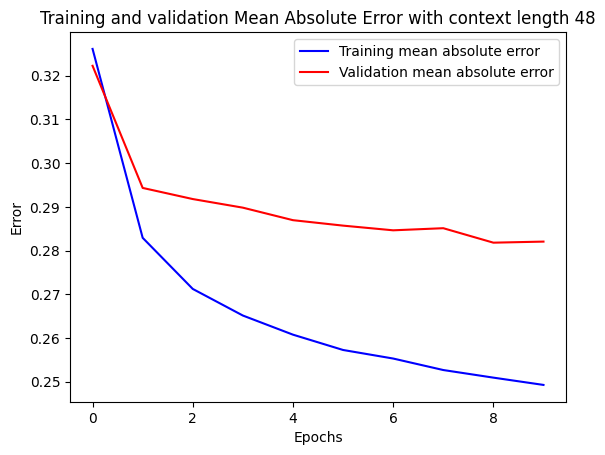

In [ ]:
visualize_error(history_288, f'Training and validation Mean Absolute Error with context length {sequence_length_288}')

- Der `Training MAE` nimmt kontinuierlich ab und erreicht am Ende einen relativ niedrigen Wert. Der `Validierungsfehler` sinkt anfangs, flacht dann aber relativ schnell ab und bleibt deutlich über dem `Trainingsfehler`.
- Es lässt sich aus der raschen Abflachung des `Validierungs-MAE` schließen, dass das Modell möglicherweise nicht genügend Kontext hat, uum genaue Vorhersagen über künftige Werte zu machen.
- Der Unterschied zwischen `Training- und Validierungsfehler` könnte auf eine leichte Überanpassung (Overfitting) hinweisen.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


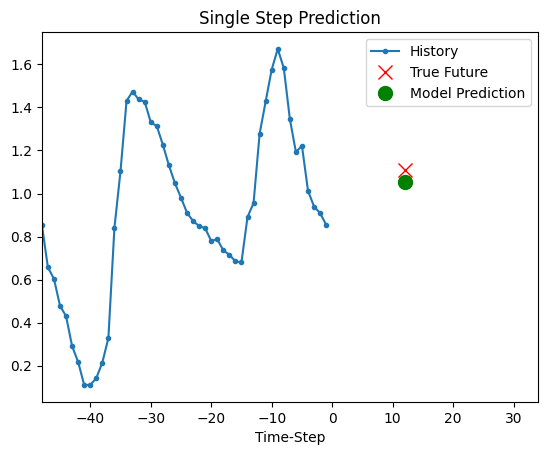

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


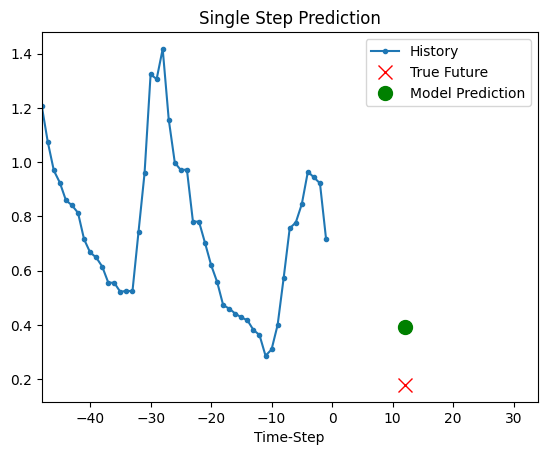

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


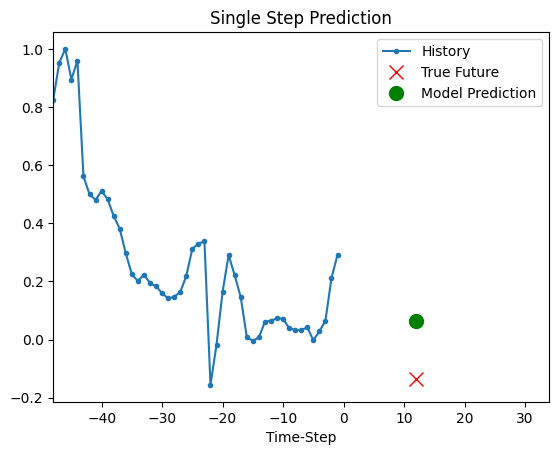

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


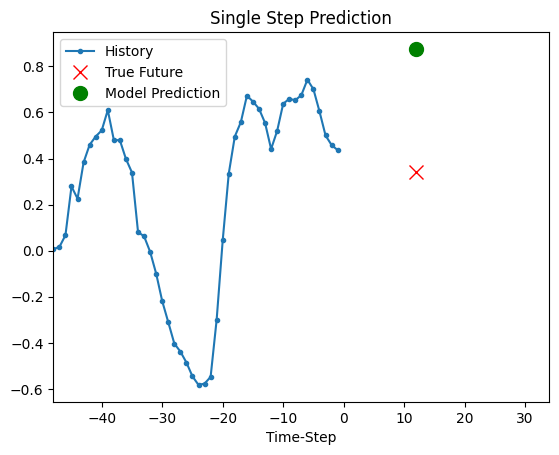

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


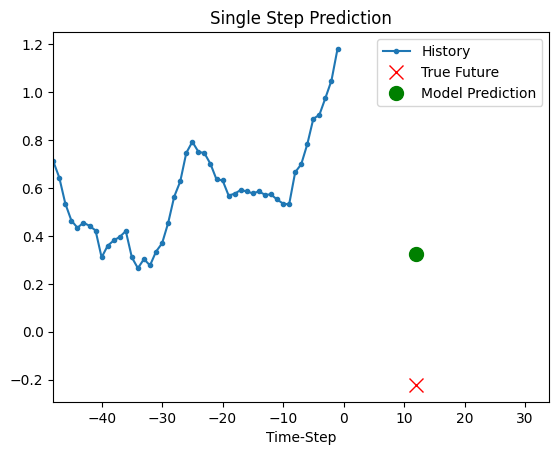

In [ ]:
for x, y in dataset_val_288.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model_288.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

- Die Modellvorhersagen unterscheiden sich erheblich von den tatsächlichen Zahlen. Dies zeigt sich durch die große Diskrepanz zwischen der Position des grünen Punkts (Vorhersagewert) und des roten Kreuzes (tatsächlicher Wert) in vielen Fällen.
- Mit Vorhersagen zu nahegelegenen Zeitpunkten erhalten wir positive Ergebnisse (erstes Diagramm). Dennoch scheint das Modell nicht in der Lage zu sein, die zukünftigen Werte korrekt vorherzusagen.
- Die geringe Kontextlänge von 288 Zeitpunkten ist wahrscheinlich nicht ausreichend, um die notwendigen Informationen zu liefern, die für eine präzise Vorhersage benötigt werden. Das Modell hat Schwierigkeiten, längerfristige Muster zu erfassen, was zu ungenauen Vorhersagen führt.

#### **Kontextgröße: `past = 720`**


In [ ]:
past_720 = 720
sequence_length_720 = int(past_720 / step)

x_train_720, dataset_train_720 = create_dataset_train(past_720, sequence_length_720)
dataset_val_720 = create_dataset_val(past_720, sequence_length_720)

print_input_and_target_shape(dataset_train_720)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [ ]:
model_720 = build_model(x_train_720, sequence_length_720)
model_720.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 120, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 120, 32)             │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_720.save('model_720.h5')

In [ ]:
history_720 = train_model(model_720, dataset_train_720, dataset_val_720)

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3226 - mean_absolute_error: 0.3978
Epoch 1: val_mean_absolute_error improved from inf to 0.32752, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - loss: 0.3225 - mean_absolute_error: 0.3977 - val_loss: 0.1688 - val_mean_absolute_error: 0.3275
Epoch 2/10
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1463 - mean_absolute_error: 0.2931
Epoch 2: val_mean_absolute_error improved from 0.32752 to 0.30547, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - loss: 0.1463 - mean_absolute_error: 0.2931 - val_loss: 0.1511 - val_mean_absolute_error: 0.3055
Epoch 3/10
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1287 - mean_absolute_error: 0.2771
Epoch 3: val_mean_absolute_error improved from 0.30547 to 0.30181, saving model to model_checkpoint.weights.h5
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - loss: 0.1287 - mean_absolute_error: 0.

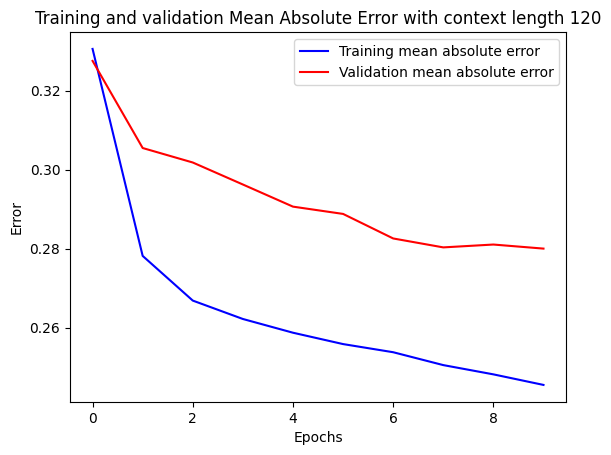

In [ ]:
visualize_error(history_720, f'Training and validation Mean Absolute Error with context length {sequence_length_720}')

- `Training MAE`: Der Fehler sinkt, ähnlich wie bei Modell 1, aber zu einem niedrigeren Endwert als bei Modell 1.
-` Validierungs-MAE`: Auch der ValidierungFehler nimmt ab, allerdings zeigt sich eine langsamere Abflachung als bei Modell 1.
- Durch die längere Kontextlänge kann das Modell relevante Informationen verwenden. Dies führt zu einer verbesserten Leistung der Validierungsdaten.
- Wie die Grafik zeigt, durch das geringere Auseinanderdriften von Trainings- und Validierungsfehlern weist das Modell eine verbesserte Generalisierungsfähigkeit auf.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


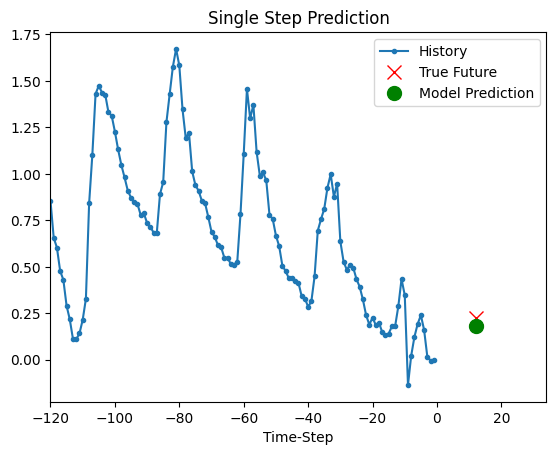

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


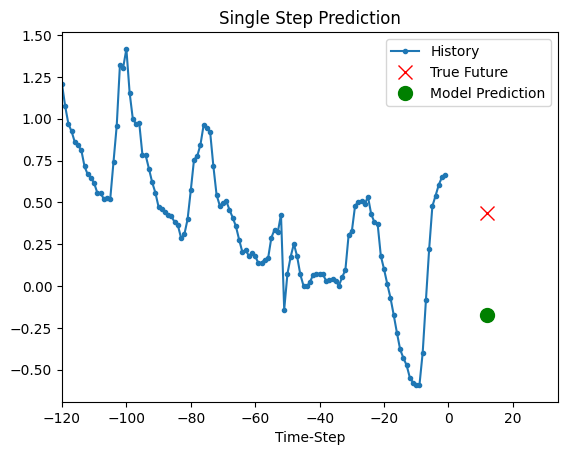

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


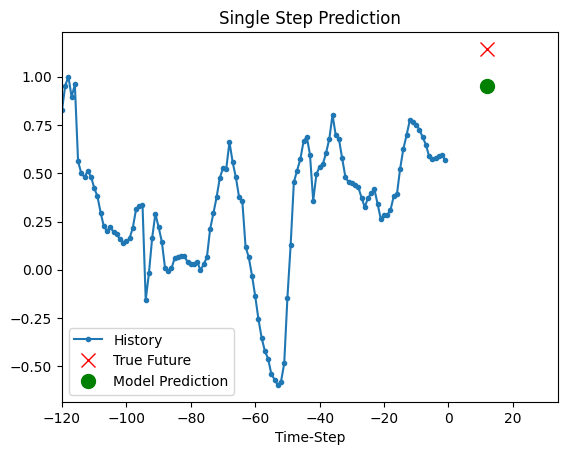

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


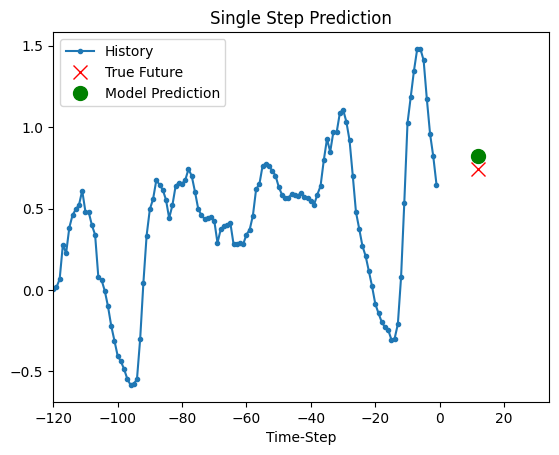

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


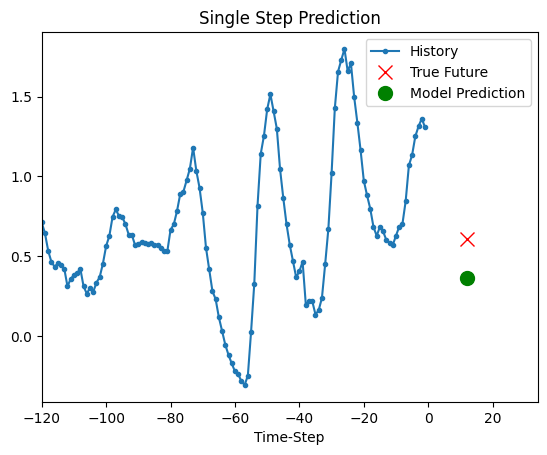

In [ ]:
for x, y in dataset_val_720.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model_720.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

- Die Prognosen sind genauer als das erste Modell, und die Differenz zwischen den tatsächlichen und den prognostizierten Werten ist in den meisten Fällen geringer.
- Das Modell zeigt eine bessere Anpassung an die Daten, vor allem in den meisten Diagrammen, wo die vorhergesagten Werte näher an den tatsächlichen Werten liegen.
- 720 Zeitpunkten scheinen eine ausgewogenere Menge an historischen Daten zu bieten, die dem Modell ermöglichen, bessere Vorhersagen zu machen. Es kann längere Muster und Trends in den Daten erkennen und so die zukünftigen Werte genauer vorhersagen.

#### **Kontextgröße: `past = 1440`**

In [ ]:
past_1440 = 1440
sequence_length_1440 = int(past_1440 / step)

x_train_1440, dataset_train_1440 = create_dataset_train(past_1440, sequence_length_1440)
dataset_val_1440 = create_dataset_val(past_1440, sequence_length_1440)

print_input_and_target_shape(dataset_train_1440)

Input shape: (256, 240, 7)
Target shape: (256, 1)


In [ ]:
model_1440 = build_model(x_train_1440, sequence_length_1440)
model_1440.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 240, 32)             │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1440.save('model_1440.h5')

In [ ]:
history_1440 = train_model(model_1440, dataset_train_1440, dataset_val_1440)

Epoch 1/10
1168/1169 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2490 - mean_absolute_error: 0.3799
Epoch 1: val_mean_absolute_error improved from inf to 0.32628, saving model to model_checkpoint.weights.h5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - loss: 0.2489 - mean_absolute_error: 0.3798 - val_loss: 0.1677 - val_mean_absolute_error: 0.3263
Epoch 2/10
1168/1169 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1318 - mean_absolute_error: 0.2817
Epoch 2: val_mean_absolute_error improved from 0.32628 to 0.29801, saving model to model_checkpoint.weights.h5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - loss: 0.1318 - mean_absolute_error: 0.2817 - val_loss: 0.1438 - val_mean_absolute_error: 0.2980
Epoch 3/10
1168/1169 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1192 - mean_absolute_error: 0.2688
Epoch 3: val_mean_absolute_error improved from 0.29801 to 0.29513, saving model to model_checkpoint.weights.h5
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - loss: 0.1192 - mean_absolute_error: 0.

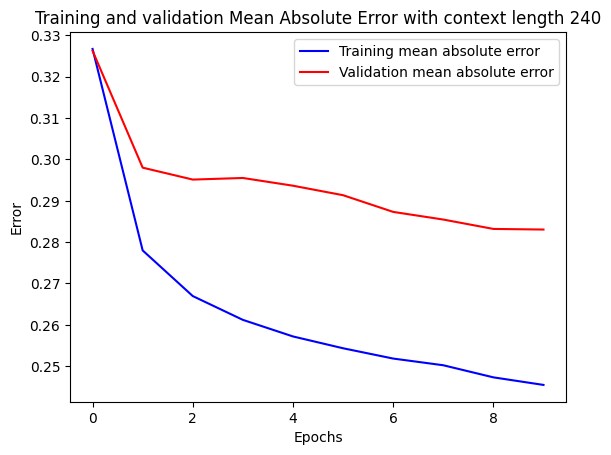

In [ ]:
visualize_error(history_1440, f'Training and validation Mean Absolute Error with context length {sequence_length_1440}')

- `Training MAE`: Der Fehler nimmt weiterhin ab und erreicht einen noch niedrigeren Wert.
- `Validierungs-MAE`: Der Validierungsfehler nimmt ab, bleibt aber stabil auf einem höheren Niveau als der Trainingsfehler.
- Es besteht die Möglichkeit, dass das Modell aufgrund einer übermäßigen Kontextlänge Probleme hat, nur die relevanten historischen Daten zu verwenden. Dies kann zu einer leichten Überanpassung führen.
- Obwohl das Modell besser auf den Trainingsdaten performt, führt die höhere Komplexität möglicherweise nicht zu einem besseren Ergebnis auf den Validierungsdaten.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


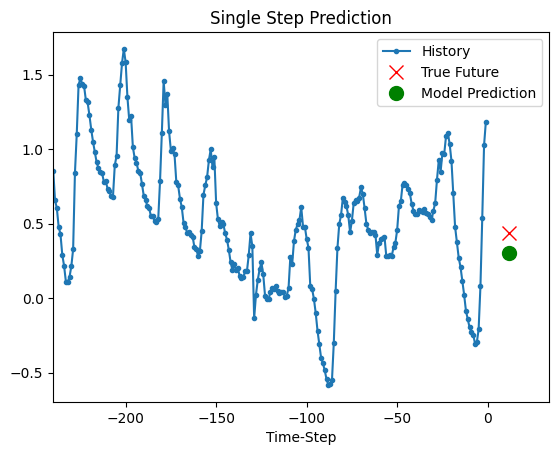

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


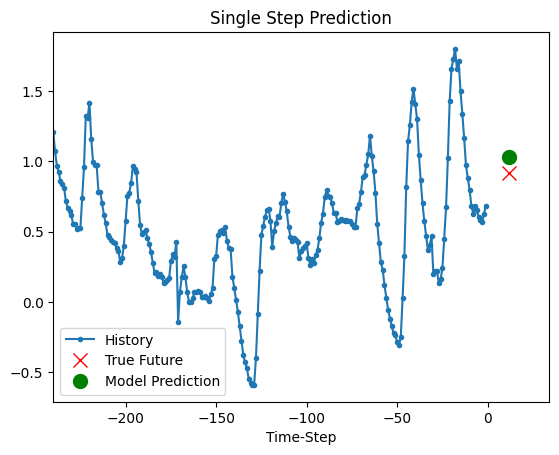

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


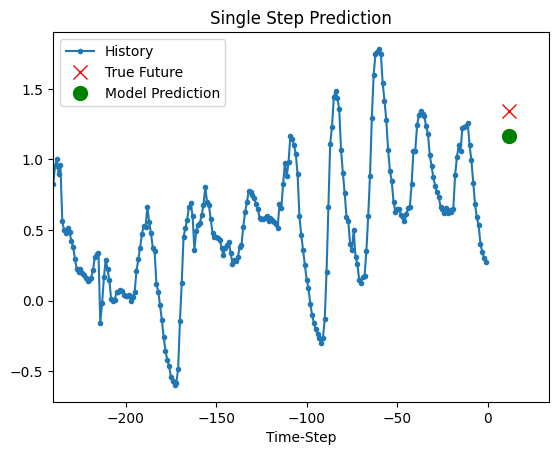

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


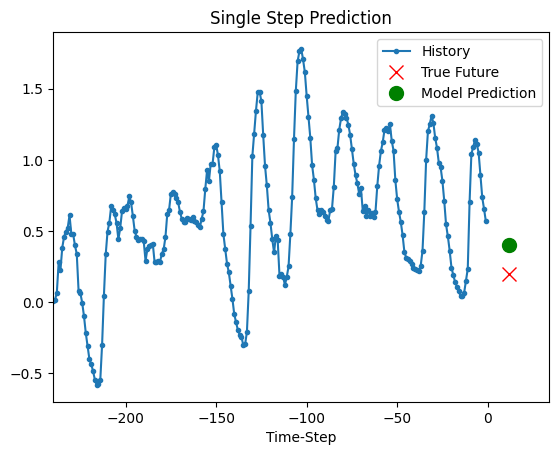

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


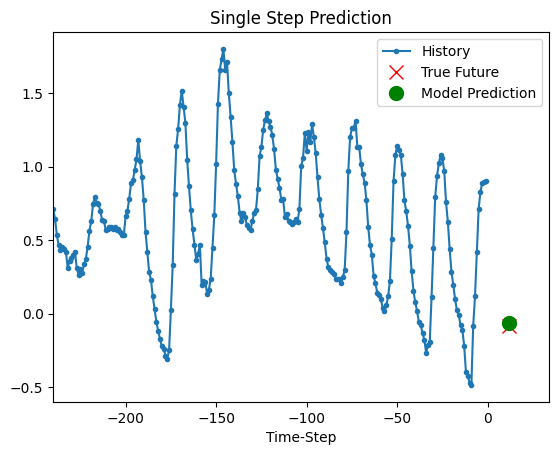

In [ ]:
for x, y in dataset_val_1440.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model_1440.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

- Das Modell zeigt gemischte Ergebnisse. Während es in einigen Fällen genaue Vorhersagen liefert, gibt es auch Fälle, in denen die Vorhersagen deutlich daneben liegen.
- Es scheint, dass das Modell Schwierigkeiten hat, aus der großen Menge an historischen Daten die relevanten Informationen herauszufiltern. Dies gilt insbesondere für Daten, die stärker schwanken.
- Die längere Kontextlänge kann dazu führen, dass das Modell mit zu vielen Informationen überfordert wird. Es könnte sein, dass das Modell versucht, zu viele irrelevante Details zu berücksichtigen, was die Vorhersagegenauigkeit beeinträchtigt. Diese Überanpassung an vergangene Muster kann bei neuen, ungesehenen Daten zu schlechteren Vorhersagen führen.

##**Zusammenfassung**

- Wie aus dem Training log von alle drei Modellen deutlich ist, dass  der Training MAE und der Validation MAE über die Epochen hinweg sinken. Dies ist ein gutes Zeichen, da es zeigt, dass das Modell sowohl die Trainingsdaten gut lernt als auch auf neuen Daten gut abschneidet. Besonders bemerkenswert ist, dass der Validation MAE nach zehnn Epochen gesunken ist. Dies zeigt eine stetige Verbesserung der Modellleistung.

 - ***Kontextlänge 48*** ist zu kurz, um längerfristige Muster in den Daten zu erkennen. Dies führt zu ungenauen Vorhersagen.
 - ***Kontextlänge 120*** bietet eine ausgewogenere und präzisere Vorhersageleistung. Das Modell ist in der Lage, relevante Muster zu erkennen, ohne von zu vielen Details überwältigt zu werden.
 - ***Kontextlänge 240*** führt zu besseren Vorhersagen. Was besonders auffällt ist, zu viele historische Daten können das Modell überfordern und zu einer Überanpassung führen, die die Generalisierungsfähigkeit verschlechtert.

- Aus all dem lässt sich die Schlussfolgerung ziehen, dass je länger die Kontextlänge ist, desto präziser die Vorhersage wird. Dennoch ist eine mittlere Kontextlänge von 120 Zeitpunkten am effektivsten. Sie bietet genug Informationen, um die Wetterdaten akkurat vorherzusagen, ohne die Gefahr der Überanpassung, die bei einer zu großen Kontextlänge auftreten kann. Eine zu kurze Kontextlänge hingegen führt zu unzureichenden Informationen und schlechterer Vorhersagequalität.




##**Quelle:**
- https://keras.io/examples/timeseries/timeseries_weather_forecasting/
- https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce
- https://blog.paperspace.com/weather-forecast-using-ltsm-networks/
- https://www.studysmarter.de/studium/informatik-studium/kuenstliche-intelligenz-studium/long-short-term-memory-networks/
- Raschka, S. (2021). Machine Learning mit Python und Keras, TensorFlow 2 und Scikit-learn : das umfassende Praxis-Handbuch für Data Science, Deep Learning und Predictive Analytics. Frechen: MITP.
- https://www.jedox.com/de/blog/fehlermasze-guete-von-forecasts-ermitteln/
- https://www.slimstock.com/de/blog/forecast-accuracy/